In [10]:
# | default_exp spc
%load_ext autoreload
%autoreload 2

# Serial Position Curve

The **serial position effect** refers to the tendency to better recall items from the beginning and end of a list, with poorer recall for middle items. It can be measured using a free recall task, where participants study a list and then recall items in any order. The resulting **serial position curve** plots recall probability by study position, capturing this characteristic pattern.

In [1]:
# | export

import jax.numpy as jnp
from jax import vmap, jit

from typing import Optional, Sequence
from jaxcmr.typing import Array, Float, Integer, Bool
from jaxcmr.experimental.repetition import all_study_positions
from jaxcmr.experimental.plotting import init_plot, plot_data, set_plot_labels
from jaxcmr.helpers import apply_by_subject, find_max_list_length

from matplotlib.axes import Axes
from matplotlib import rcParams  # type: ignore


## Simple Case: When Study Lists are Uniform
With a 2-D `recalls` array tracking trial by recall position array of recalled items where non-zero values indicate the study position of the recalled item, the serial position curve can be calculated by tabulating the frequency of each non-zero value across trials then dividing by the number of trials:

In [2]:
# | exports

def fixed_pres_spc(
    recalls: Integer[Array, " trial_count recall_positions"], list_length: int
) -> Float[Array, " study_positions"]:
    """Returns recall rate as a function of study position, assuming uniform study lists.

    Args:
        recalls: trial by recall position array of recalled items. 1-indexed; 0 for no recall.
        list_length: the length of the study list.
    """
    return jnp.bincount(recalls.flatten(), length=list_length + 1)[1:] / len(recalls)

We maintain this specialized implementation for time-sensitive use cases and demonstration purposes.

## Complex Case: Item Repetitions

If items can be repeated within the same study list, values in our 2-D `recalls` can only indicate one of the study positions of the recalled item.

To account for this, we additionally use a 2-D `presentations` array tracking trial by study position for presented items.
A helper function `all_study_positions` is mapped over the `recalls` array to create a 3-D array of study positions for each recalled item, where the first dimension is the trial, the second dimension is the recall position, and the third dimension is the study position.
This allows us to calculate the serial position curve by tabulating the frequency of each study position across trials and recall positions, then dividing by the number of trials and the maximum number of item repetitions.

The resulting serial position curve counts recalls of items with multiple study positions as a single recall of *all* of those study positions. This function works even for study lists without repetitions, but it is less efficient than the simple case.

In [ ]:
# | exports

def spc(
    recalls: Integer[Array, " trial_count recall_positions"],
    presentations: Integer[Array, " trial_count study_positions"],
    list_length: int,
    size: int = 3,
) -> Float[Array, " study_positions"]:
    """Returns recall rate as a function of study position.

    Args:
        recalls: trial by recall position array of recalled items. 1-indexed; 0 for no recall.
        presentations: trial by study position array of presented items. 1-indexed.
        list_length: the length of the study list.
        size: maximum number of study positions an item can be presented at.
    """
    expanded_recalls = vmap(
        vmap(all_study_positions, in_axes=(0, None, None)), in_axes=(0, 0, None)
    )(recalls, presentations, size)

    counts = jnp.bincount(expanded_recalls.flatten(), length=list_length + 1)[1:]
    return counts / len(expanded_recalls)

## Plotting the Serial Position Curve
The `plot_spc` function produces a simple line plot for the SPC across multiple datasets and/or trial masks.

In [4]:
#| exports

def plot_spc(
    datasets: Sequence[dict[str, jnp.ndarray]] | dict[str, jnp.ndarray],
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    distances: Optional[Float[Array, "word_count word_count"]] = None,
    color_cycle: Optional[list[str]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
    size: int = 3,
) -> Axes:
    """Returns Axes object with plotted serial position curve for datasets and trial masks.

    Args:
        datasets: Datasets containing trial data to be plotted.
        trial_masks: Masks to filter trials in datasets.
        color_cycle: List of colors for plotting each dataset.
        distances: Unused, included for compatibility with other plotting functions.
        labels: Names for each dataset for legend, optional.
        contrast_name: Name of contrast for legend labeling, optional.
        axis: Existing matplotlib Axes to plot on, optional.
        size: Maximum number of study positions an item can be presented at.
    """
    axis = init_plot(axis)

    if color_cycle is None:
        color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

    if labels is None:
        labels = [""] * len(datasets)

    if isinstance(datasets, dict):
        datasets = [datasets]

    if isinstance(trial_masks, jnp.ndarray):
        trial_masks = [trial_masks]

    max_list_length = find_max_list_length(datasets, trial_masks)
    for data_index, data in enumerate(datasets):
        subject_values = jnp.vstack(
            apply_by_subject(
                data,
                trial_masks[data_index],
                jit(spc, static_argnames=("size", "list_length")),
                size,
            )
        )

        color = color_cycle.pop(0)
        plot_data(
            axis,
            jnp.arange(max_list_length, dtype=int) + 1,
            subject_values,
            labels[data_index],
            color,
        )

    set_plot_labels(axis, "Study Position", "Recall Rate", contrast_name)
    return axis

## Tests

### Equivalent Outputs For Uniform Study Lists

When study lists are fixed, the two implementations should produce the same results. We will confirm this by comparing the results of the two implementations for a fixed study list.

In [5]:
presentation = jnp.array([[1, 2, 3, 4, 5, 6, 7, 8], [1, 2, 3, 4, 5, 6, 7, 8]])
trial = jnp.array([[8, 7, 1, 2, 3, 5, 6, 4, 0], jnp.zeros(9, dtype=int)])
true_spc = jnp.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
list_length = presentation.shape[1]

assert jnp.allclose(spc(trial, presentation, list_length), true_spc)
assert jnp.allclose(fixed_pres_spc(trial, list_length), true_spc)
fixed_pres_spc(trial, list_length)

Array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], dtype=float32)

### Insensitivity to Zero Padding

Padding either presentation or trial with 0s should not change the result.

In [6]:
# new example where item 8 is presented twice and recalled first
presentation = jnp.array([[1, 2, 3, 4, 5, 6, 7, 8, 8, 0]])
trial = jnp.array([[8, 7, 1, 2, 3, 5, 6, 4, 0]])

assert jnp.allclose(
    spc(trial, presentation, 9),
    spc(trial[:, :-1], presentation[:, :-1], 9),
)

spc(trial, presentation, 9)

Array([1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

### Sensitivity to Item Repetitions

The resulting serial position curve counts recalls of items with multiple study positions as a single recall of *all* of those study positions.

In [7]:
presentation = jnp.array([[1, 2, 3, 4, 4]])
trial = jnp.array([[1, 2, 3, 4]])

assert jnp.allclose(
    spc(trial, presentation, 5),
    jnp.array([1., 1., 1., 1., 1.]),
)

spc(trial, presentation, 5)

Array([1., 1., 1., 1., 1.], dtype=float32)

## Examples

The output of our `spc` function is a vector of length equal to the number of study positions, with each element representing the probability of recalling an item from that position. The function itself can be readily transformed with `jax`'s functional transformations, such as `jit` or `vmap`, to improve performance for larger datasets.

Our plotting function `plot_spc` takes this vector and creates a line plot, with the x-axis representing the study positions and the y-axis representing the recall rates.

In [8]:
from jaxcmr.helpers import generate_trial_mask, load_data, find_project_root
import os

Uniform study lists case:

Array([0.6428572 , 0.56904763, 0.50476193, 0.45238096, 0.40952381,
       0.3857143 , 0.35000002, 0.3357143 , 0.3357143 , 0.3       ,
       0.32380953, 0.3261905 , 0.3261905 , 0.32380953, 0.29761904,
       0.3119048 , 0.32380953, 0.29761904, 0.27857143, 0.27142859,
       0.2904762 , 0.28333333, 0.27857143, 0.32857144, 0.2809524 ,
       0.3309524 , 0.32857144, 0.3166667 , 0.3261905 , 0.33809525,
       0.37380955, 0.32380953, 0.36190477, 0.3404762 , 0.35952383,
       0.37619048, 0.3904762 , 0.42380953, 0.41428572, 0.34523812],      dtype=float32)

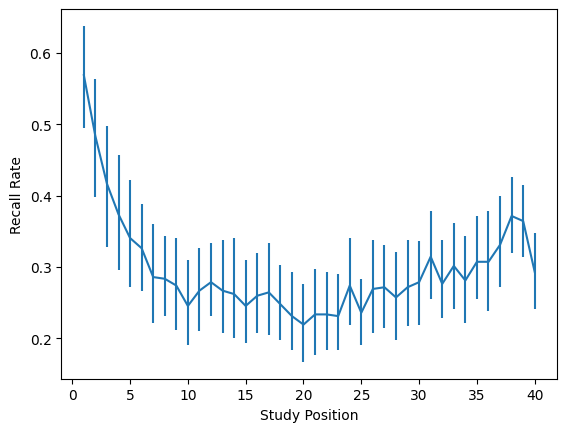

In [9]:
# parameters
run_tag = "SPC"
data_name = "LohnasKahana2014"
data_query = "data['list_type'] == 1"
data_path =  os.path.join(find_project_root(), "data/LohnasKahana2014.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot SPC
plot_spc(data, generate_trial_mask(data, data_query))
jit(spc, static_argnames=("size", "list_length"))(
    recalls[trial_mask], presentations[trial_mask], list_length
)

Study lists where every item is repeated once immediately after its first presentation. In this example, each pair of successive study positions in the plot should produce the same recall rate.

Array([0.7571429 , 0.70952386, 0.6880953 , 0.6666667 , 0.6642857 ,
       0.6952381 , 0.6738095 , 0.6761905 , 0.64761907, 0.64761907,
       0.63809526, 0.59761906, 0.62857145, 0.5952381 , 0.6428572 ,
       0.56904763, 0.6047619 , 0.5928572 , 0.5857143 , 0.6047619 ,
       0.552381  , 0.56904763, 0.57380956, 0.552381  , 0.6119048 ,
       0.56666666, 0.6047619 , 0.6119048 , 0.6214286 , 0.6166667 ,
       0.6452381 , 0.6238096 , 0.6166667 , 0.6571429 , 0.6666667 ,
       0.68333334, 0.6952381 , 0.6857143 , 0.6714286 , 0.67857146],      dtype=float32)

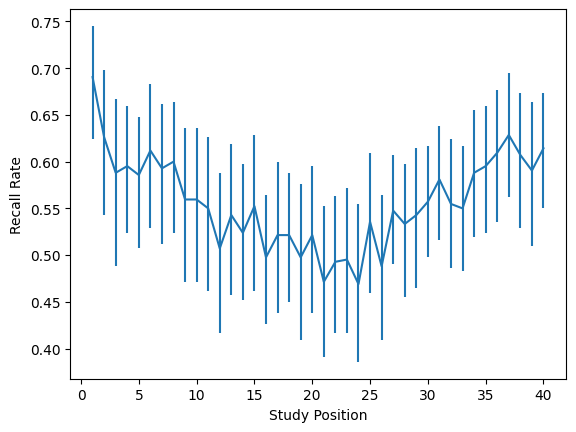

In [15]:
# parameters
run_tag = "SPC"
data_name = "LohnasKahana2014"
data_query = "data['list_type'] == 3"
data_path =  os.path.join(find_project_root(), "data/LohnasKahana2014.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot SPC
plot_spc(data, generate_trial_mask(data, data_query))
jit(spc, static_argnames=("size", "list_length"))(
    recalls[trial_mask], presentations[trial_mask], list_length
)

Array([0.7690477 , 0.7476191 , 0.7047619 , 0.6976191 , 0.6952381 ,
       0.7357143 , 0.6976191 , 0.6952381 , 0.6642857 , 0.6761905 ,
       0.6642857 , 0.61904764, 0.6547619 , 0.6214286 , 0.6666667 ,
       0.58809525, 0.6309524 , 0.60952383, 0.6047619 , 0.6238096 ,
       0.57380956, 0.5928572 , 0.5904762 , 0.56904763, 0.63809526,
       0.57857144, 0.6238096 , 0.6333334 , 0.6357143 , 0.6309524 ,
       0.6738095 , 0.6428572 , 0.6404762 , 0.6761905 , 0.7047619 ,
       0.7047619 , 0.7214286 , 0.7166667 , 0.6976191 , 0.70238096],      dtype=float32)

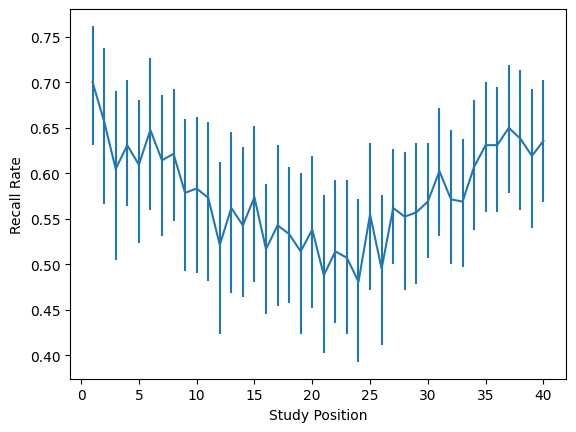

In [14]:
# parameters
run_tag = "SPC"
data_name = "LohnasKahana2014"
data_query = "data['list_type'] == 3"
data_path =  os.path.join(find_project_root(), "data/RepeatedRecallsLohnasKahana2014.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot SPC
plot_spc(data, generate_trial_mask(data, data_query))
jit(spc, static_argnames=("size", "list_length"))(
    recalls[trial_mask], presentations[trial_mask], list_length
)